In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sklearn
from sklearn.model_selection import train_test_split

from tqdm import trange 

from utils import AlongAcrossComponent, drifterDailyResampling, srl

import warnings

In [2]:
iso600 = np.loadtxt('../data/bathy/smooth_600m_isobath.txt')
x600 = iso600[:,0]
y600 = iso600[:,1]

iso000 = np.loadtxt('../data/bathy/smooth_0m_isobath.txt')
x000 = iso000[:,0]
y000 = iso000[:,1]

In [3]:
bathy = xr.open_dataset('../data/bathy/GEBCO_02_Dec_2022_8bb5cd71a07e/gebco_2022_n62.0_s59.0_w-49.0_e-40.0.nc')

gdp = xr.open_dataset('../data/GDP/processed_gdp_data.nc')

geo = xr.open_dataset('../data/ADSC/geo_daily_gdp.nc')
geo_ekman = xr.open_dataset('../data/ADSC/geo_ekman_daily_gdp.nc').isel(depth=0)

In [4]:
geo.time.values, geo_ekman.time.values

(array(['1993-01-02T00:00:00.000000000', '1993-01-03T00:00:00.000000000',
        '1993-01-04T00:00:00.000000000', ...,
        '2021-12-29T00:00:00.000000000', '2021-12-30T00:00:00.000000000',
        '2021-12-31T00:00:00.000000000'], dtype='datetime64[ns]'),
 array(['1993-01-02T12:00:00.000000000', '1993-01-03T12:00:00.000000000',
        '1993-01-04T12:00:00.000000000', ...,
        '2021-12-29T12:00:00.000000000', '2021-12-30T12:00:00.000000000',
        '2021-12-31T12:00:00.000000000'], dtype='datetime64[ns]'))

In [5]:
lon_min, lon_max = -49, -40
lat_min, lat_max = 59, 62

In [6]:
std_along = []
std_across = []
std_u = []
std_v = []

corr_coeff_along = []
corr_coeff_across = []
corr_coeff_u = []
corr_coeff_v = []

rmse_u = []
rmse_v = []
rmse_along = []
rmse_across = []

varexp_u = []
varexp_v = []
varexp_along = []
varexp_across = []

for n_d in trange(len(gdp.traj)):

    drifter = gdp.isel(traj=n_d)
            
    drifter = drifter.where(~np.isnan(drifter.lon), drop=True)

    # Check that the drifter has more than 24hr of data
    if (int(drifter.time.values[-1]-drifter.time.values[0])*1e-9)/3600 > 36:

        time_00, lon_00, lat_00, U_00, V_00, along_00, across_00 = drifterDailyResampling(geo.time.values, drifter)
        time_12, lon_12, lat_12, U_12, V_12, along_12, across_12 = drifterDailyResampling(geo_ekman.time.values, drifter)


        #Extract velocities data corresponding to resampled drifter data
        geo_lagmap = geo.sel(
            longitude=xr.DataArray(lon_00, dims="points"), 
            latitude=xr.DataArray(lat_00, dims="points"), 
            time=xr.DataArray(time_00, dims="points"), 
            method='nearest'
            )
        mask_geo = ~np.isnan(geo_lagmap.ugos.values) #Mask where geo has a landmask
        along_geo, across_geo  = AlongAcrossComponent(lon_00[mask_geo], lat_00[mask_geo], 
                geo_lagmap.ugos.values[mask_geo] + 1j*geo_lagmap.vgos.values[mask_geo])


        ek_lagmap = geo_ekman.sel(
            longitude=xr.DataArray(lon_12, dims="points"), 
            latitude=xr.DataArray(lat_12, dims="points"), 
            time=xr.DataArray(time_12, dims="points"), 
            method='nearest'
            )
        mask_ekman = ~np.isnan(ek_lagmap.uo.values) #Mask where geo+ekman has a landmask
        along_ek, across_ek  = AlongAcrossComponent(lon_12[mask_ekman], lat_12[mask_ekman], 
                ek_lagmap.uo.values[mask_ekman] + 1j*ek_lagmap.vo.values[mask_ekman])


        #Compute the correlations
        corr_along_geo = np.abs(np.corrcoef(along_00[mask_geo], along_geo)[0, 1])
        corr_along_ek = np.abs(np.corrcoef(along_12[mask_ekman], along_ek)[0, 1])
        
        corr_across_geo = np.abs(np.corrcoef(across_00[mask_geo], across_geo)[0, 1])
        corr_across_ek = np.abs(np.corrcoef(across_12[mask_ekman], across_ek)[0, 1])
        
        corr_u_geo = np.abs(np.corrcoef(U_00[mask_geo], geo_lagmap.ugos.values[mask_geo])[0, 1])
        corr_u_ek = np.abs(np.corrcoef(U_12[mask_ekman], ek_lagmap.uo.values[mask_ekman])[0, 1])
        
        corr_v_geo = np.abs(np.corrcoef(V_00[mask_geo], geo_lagmap.vgos.values[mask_geo])[0, 1])
        corr_v_ek = np.abs(np.corrcoef(V_12[mask_ekman], ek_lagmap.vo.values[mask_ekman])[0, 1])
        
        corr_coeff_along.append([corr_along_geo, corr_along_ek])
        corr_coeff_across.append([corr_across_geo, corr_across_ek])
        corr_coeff_u.append([corr_u_geo, corr_u_ek])
        corr_coeff_v.append([corr_v_geo, corr_v_ek])
        
        #Compute the standard deviation
        std_drift_along = np.mean([np.std(along_00[mask_geo]), np.std(along_12[mask_ekman])])
        std_drift_across = np.mean([np.std(across_00[mask_geo]), np.std(across_12[mask_ekman])])
        std_drift_u = np.mean([np.std(U_00[mask_geo]),np.std(U_12[mask_ekman])])
        std_drift_v = np.mean([np.std(V_00[mask_geo]), np.std(V_12[mask_ekman])])
        
        std_along.append([std_drift_along, np.std(along_geo), np.std(along_ek)])
        std_across.append([std_drift_across, np.std(across_geo), np.std(across_ek)])
        std_u.append([std_drift_u, np.std(geo_lagmap.ugos.values[mask_geo]), np.std(ek_lagmap.uo.values[mask_ekman])])
        std_v.append([std_drift_v, np.std(geo_lagmap.vgos.values[mask_geo]), np.std(ek_lagmap.vo.values[mask_ekman])])

        ## RMSE

        rmse_uek = np.sqrt(np.mean((U_12[mask_ekman] - ek_lagmap.uo.values[mask_ekman])**2)) 
        rmse_ugeo = np.sqrt(np.mean((U_00[mask_geo] - geo_lagmap.ugos.values[mask_geo])**2))

        rmse_vek = np.sqrt(np.mean((V_12[mask_ekman] - ek_lagmap.vo.values[mask_ekman])**2)) 
        rmse_vgeo = np.sqrt(np.mean((V_00[mask_geo] - geo_lagmap.vgos.values[mask_geo])**2))

        rmse_alek = np.sqrt(np.mean((along_12[mask_ekman] - along_ek)**2)) 
        rmse_algeo = np.sqrt(np.mean((along_00[mask_geo] - along_geo)**2))

        rmse_acek = np.sqrt(np.mean((across_12[mask_ekman] - across_ek)**2)) 
        rmse_acgeo = np.sqrt(np.mean((across_00[mask_geo] - across_geo)**2))

        rmse_u.append([rmse_ugeo, rmse_uek])
        rmse_v.append([rmse_vgeo, rmse_vek])
        rmse_along.append([rmse_algeo, rmse_alek])
        rmse_across.append([rmse_acgeo, rmse_acek])

        ## VARIANCE EXPLAINED

        varexp_uek = (1-(np.var(U_12[mask_ekman] - ek_lagmap.uo.values[mask_ekman]) / np.var(U_12[mask_ekman])))
        varexp_ugeo = (1-(np.var(U_00[mask_geo] - geo_lagmap.ugos.values[mask_geo]) / np.var(U_00[mask_geo])))
        
        varexp_vek = (1-(np.var(V_12[mask_ekman] - ek_lagmap.vo.values[mask_ekman]) / np.var(V_12[mask_ekman])))
        varexp_vgeo = (1-(np.var(V_00[mask_geo] - geo_lagmap.vgos.values[mask_geo]) / np.var(V_00[mask_geo])))
        
        varexp_alek = (1-(np.var(along_12[mask_ekman] - along_ek) / np.var(along_12[mask_ekman])))
        varexp_algeo = (1-(np.var(along_00[mask_geo] - along_geo) / np.var(along_00[mask_geo])))
        
        varexp_acek = (1-(np.var(across_12[mask_ekman] - across_ek) / np.var(across_12[mask_ekman])))
        varexp_acgeo = (1-(np.var(across_00[mask_geo] - across_geo) / np.var(across_00[mask_geo])))
        
        varexp_u.append([varexp_ugeo, varexp_uek])
        varexp_v.append([varexp_vgeo, varexp_vek])
        varexp_along.append([varexp_algeo, varexp_alek])
        varexp_across.append([varexp_acgeo, varexp_acek])


100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


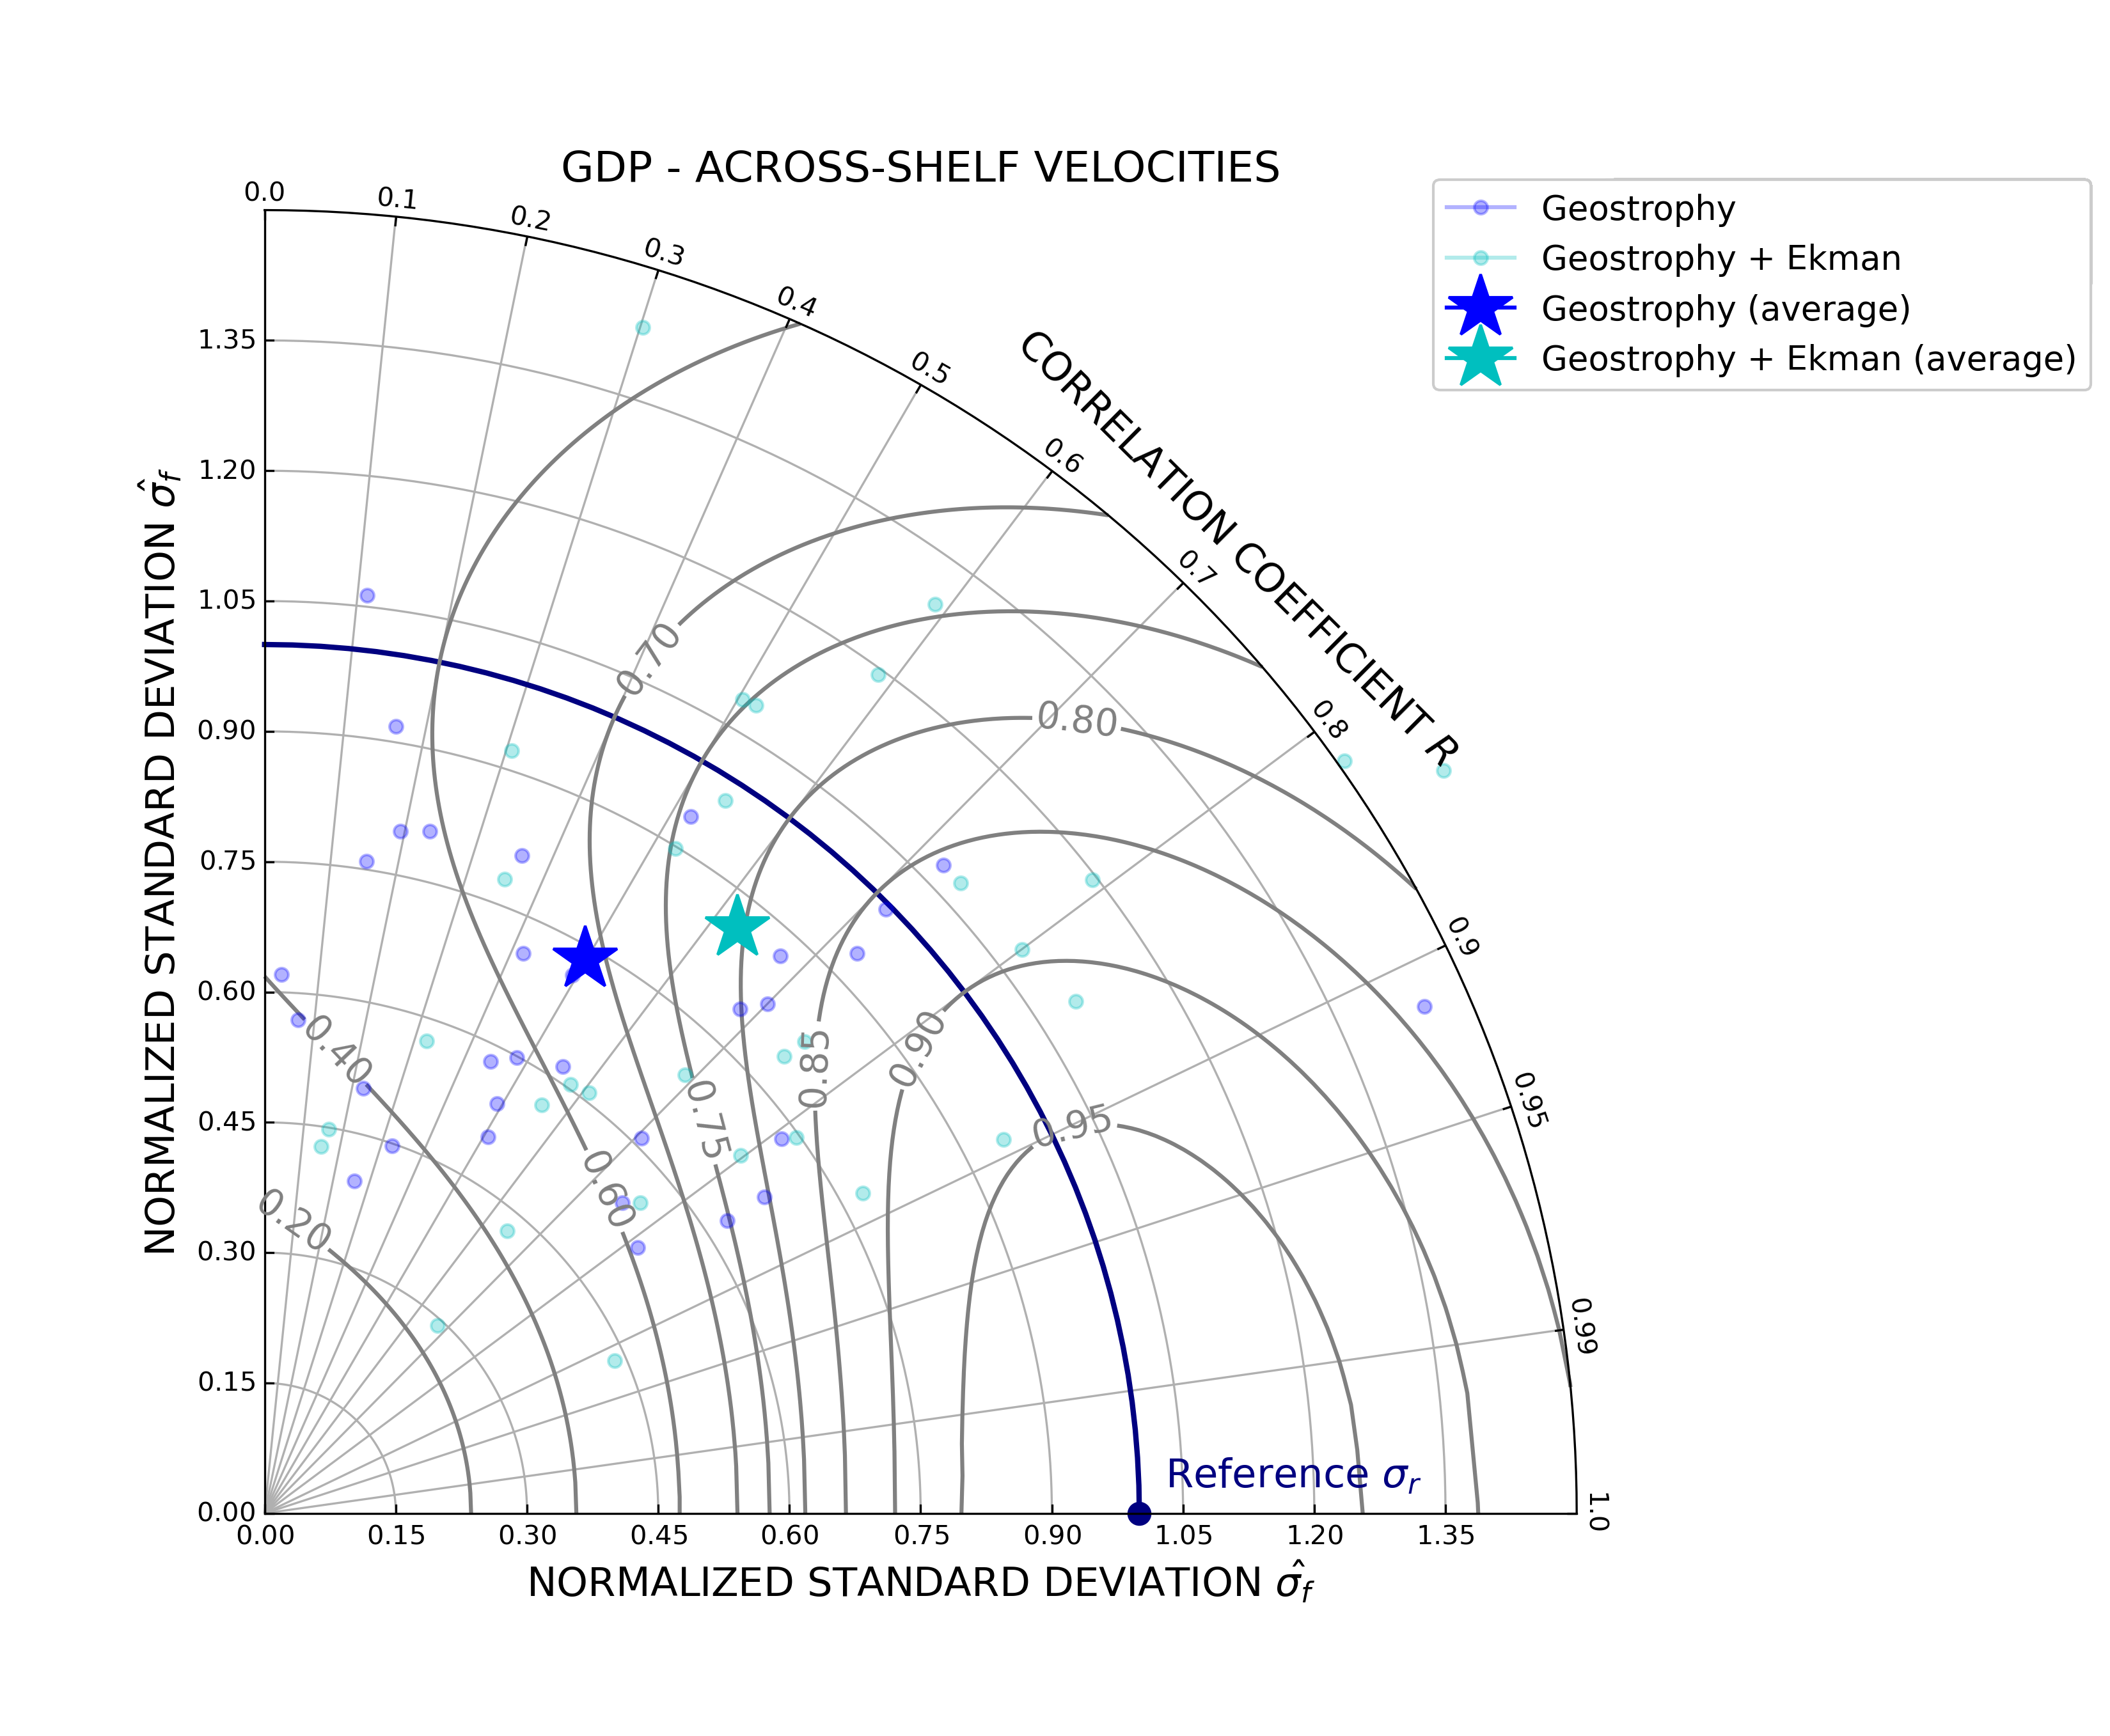

In [8]:
# Standard deviation of observed data
obsSTD = 1.0

# Standard deviation of each predicted data
s_geo= np.array(std_across)[:, 1]/np.array(std_across)[:, 0]

s_ek = np.array(std_across)[:, 2]/np.array(std_across)[:, 0]

smean = [
    np.mean(s_geo),
    np.mean(s_ek)
]

s = np.concatenate((s_geo, s_ek, smean), axis=None)

# The correlation coefficient of each predicted data
r_geo = np.array(corr_coeff_across)[:, 0]
r_ek = np.array(corr_coeff_across)[:, 1]

rmean = [
    np.mean(r_geo),
    np.mean(r_ek)
]

r = np.concatenate((r_geo, r_ek, rmean), axis=None)

# Labels of each predicted data
l_geo = ['Geostrophy']*len(s_geo)
l_ek = ['Geostrophy + Ekman']*len(s_ek)

lmean = ['Geostrophy (average)', 'Geostrophy + Ekman (average)']

l = np.concatenate((l_geo, l_ek, lmean), axis=None)

cs = np.concatenate((['b']*len(s_geo), ['c']*len(s_ek), ['b', 'c']), axis=None)

a = (np.zeros(len(std_across)))
a[0] = 1

boolean = np.concatenate((a,a, [True, True]))

# Output file name
fname = 'TaylorDiagram.jpg'

rnd = ['o']*len(std_across)

mark = np.concatenate((rnd, rnd, ['*', '*']))

size = np.ones(len(mark))*5
size[-2:] = 25

alpha = np.ones(len(mark))*0.3
alpha[-2:] = 1

srl(obsSTD, s, r, l, boolean, fname, cs, mark, size, alpha, 'GDP - ACROSS-SHELF VELOCITIES')

warnings.filterwarnings('ignore')

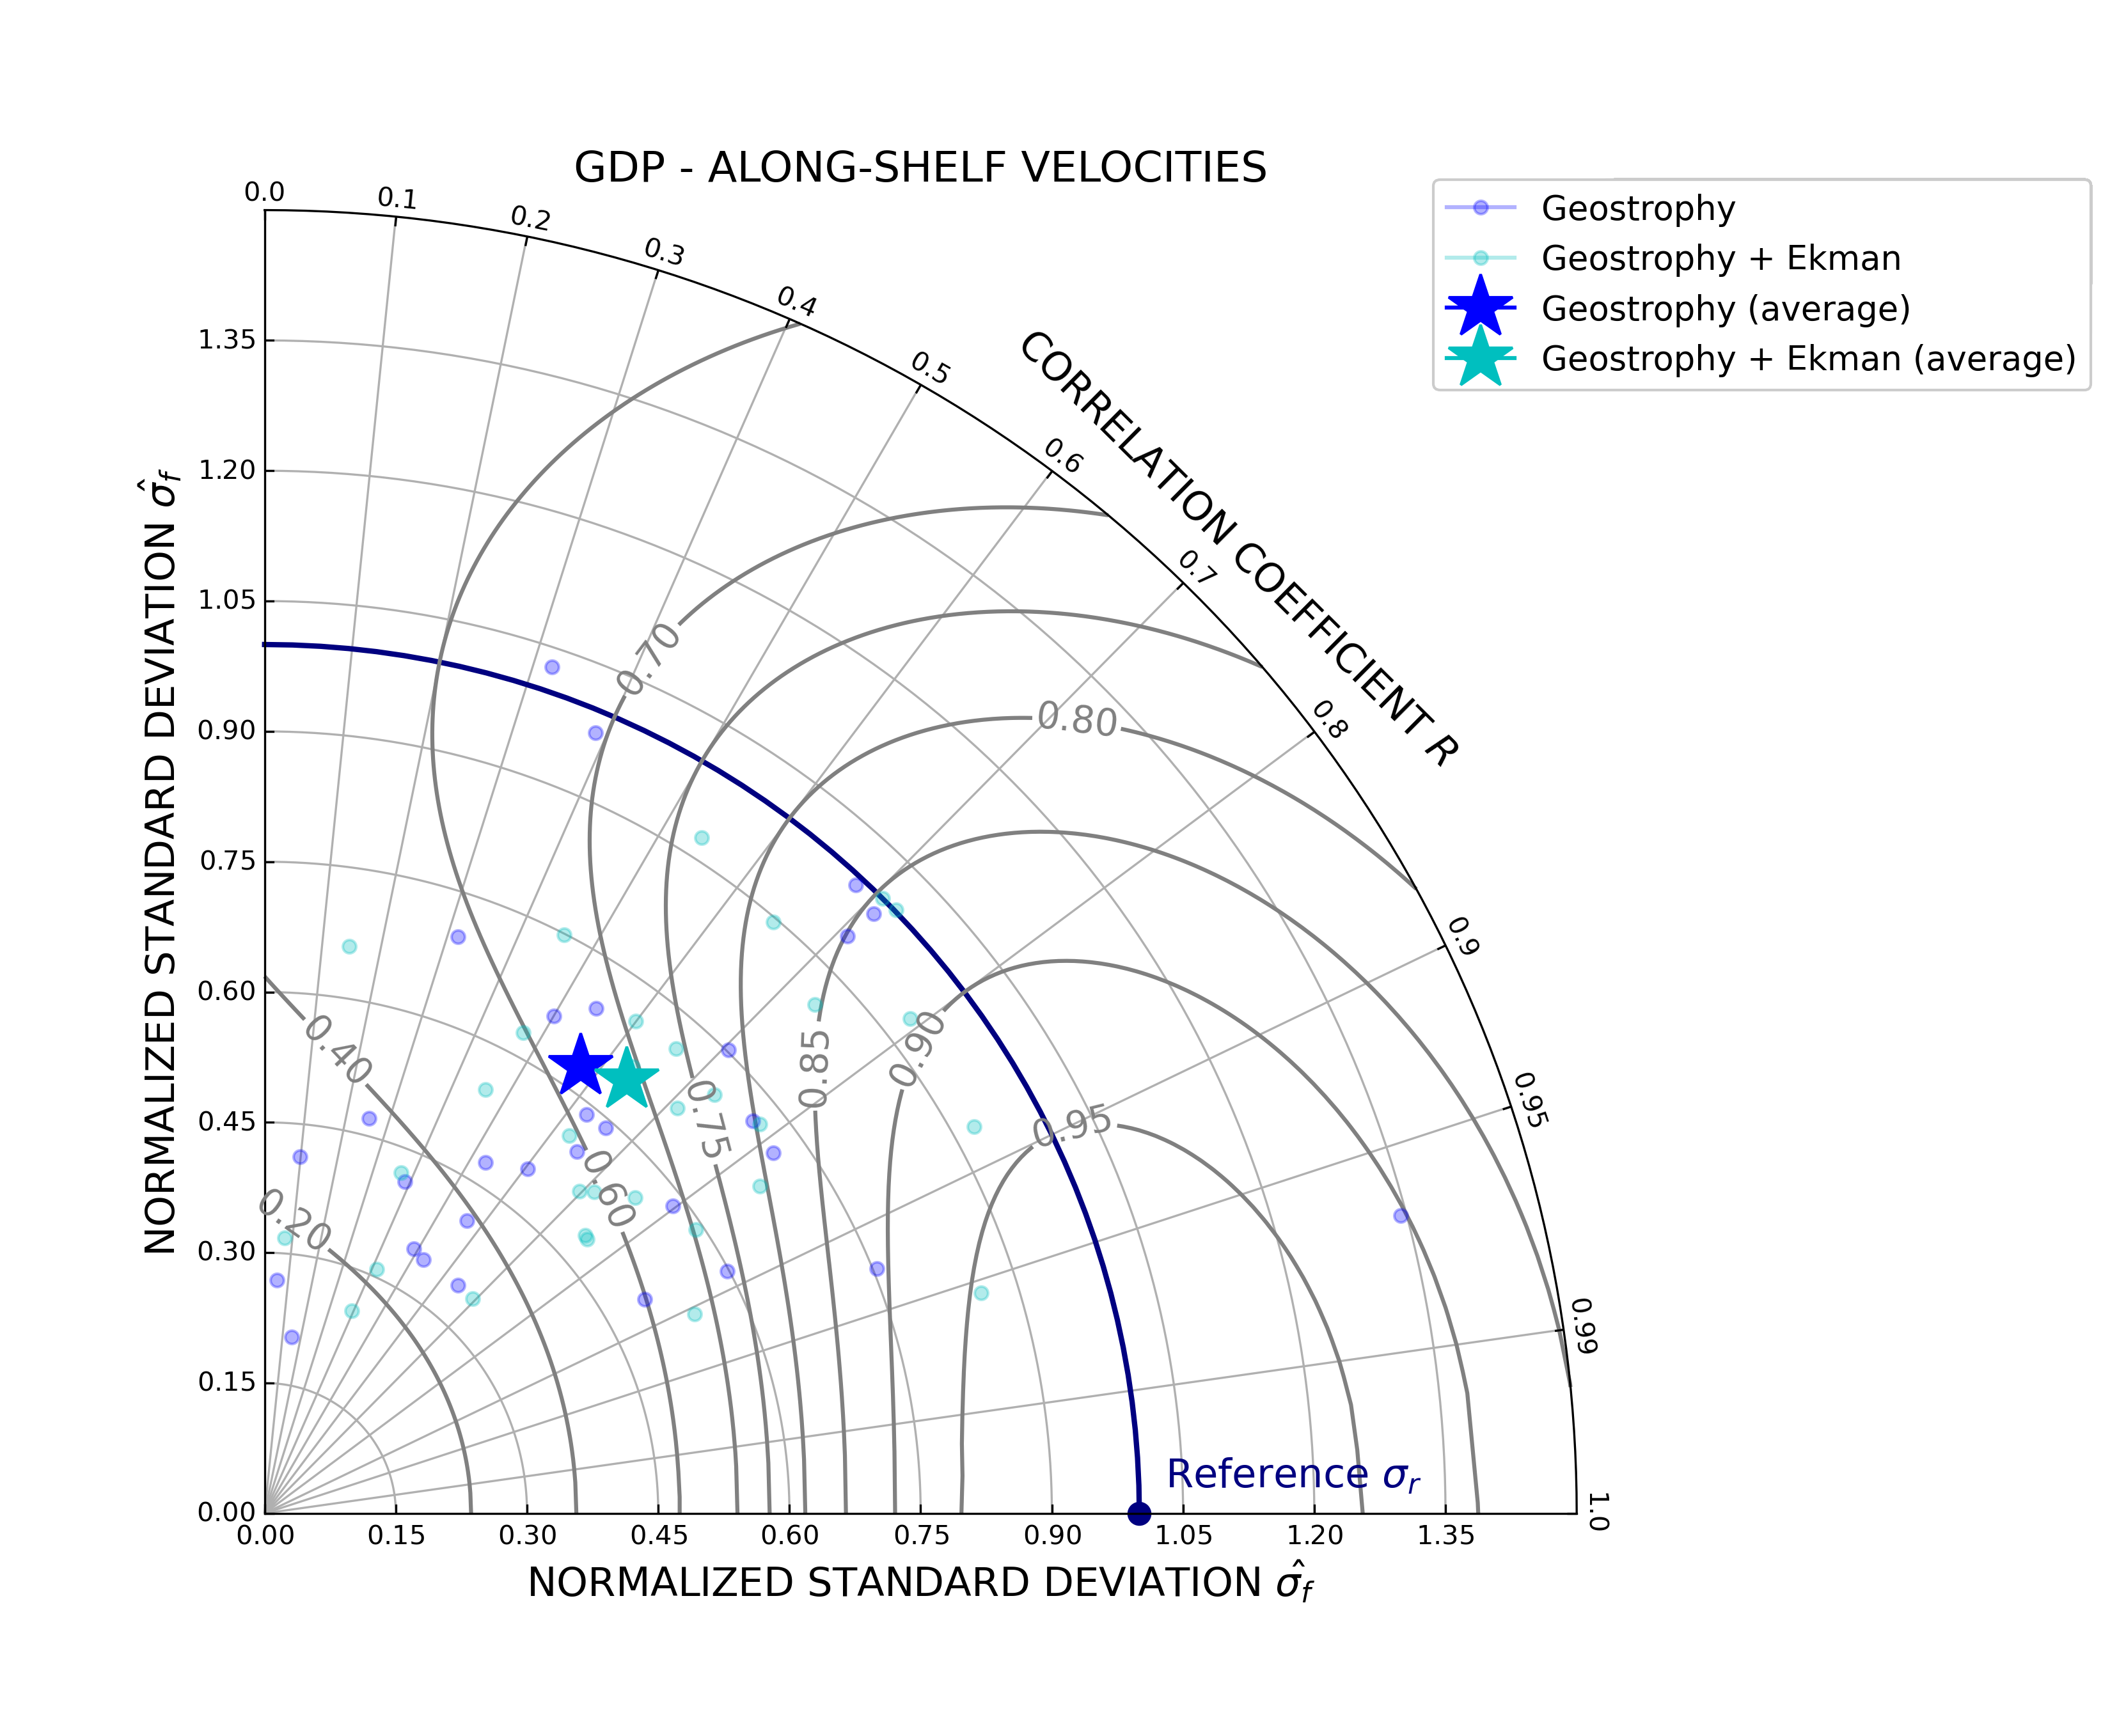

In [9]:
# Standard deviation of observed data
obsSTD = 1.0

# Standard deviation of each predicted data
s_geo= np.array(std_along)[:, 1]/np.array(std_along)[:, 0]

s_ek = np.array(std_along)[:, 2]/np.array(std_along)[:, 0]

smean = [
    np.mean(s_geo),
    np.mean(s_ek)
]

s = np.concatenate((s_geo, s_ek, smean), axis=None)

# The correlation coefficient of each predicted data
r_geo = np.array(corr_coeff_along)[:, 0]
r_ek = np.array(corr_coeff_along)[:, 1]

rmean = [
    np.mean(r_geo),
    np.mean(r_ek)
]

r = np.concatenate((r_geo, r_ek, rmean), axis=None)

# Labels of each predicted data
l_geo = ['Geostrophy']*len(s_geo)
l_ek = ['Geostrophy + Ekman']*len(s_ek)

lmean = ['Geostrophy (average)', 'Geostrophy + Ekman (average)']

l = np.concatenate((l_geo, l_ek, lmean), axis=None)

cs = np.concatenate((['b']*len(s_geo), ['c']*len(s_ek), ['b', 'c']), axis=None)

a = (np.zeros(len(std_along)))
a[0] = 1

boolean = np.concatenate((a,a, [True, True]))

# Output file name
fname = 'TaylorDiagram.jpg'

rnd = ['o']*len(std_along)

mark = np.concatenate((rnd, rnd, ['*', '*']))

size = np.ones(len(mark))*5
size[-2:] = 25

alpha = np.ones(len(mark))*0.3
alpha[-2:] = 1

srl(obsSTD, s, r, l, boolean, fname, cs, mark, size, alpha, 'GDP - ALONG-SHELF VELOCITIES')

warnings.filterwarnings('ignore')

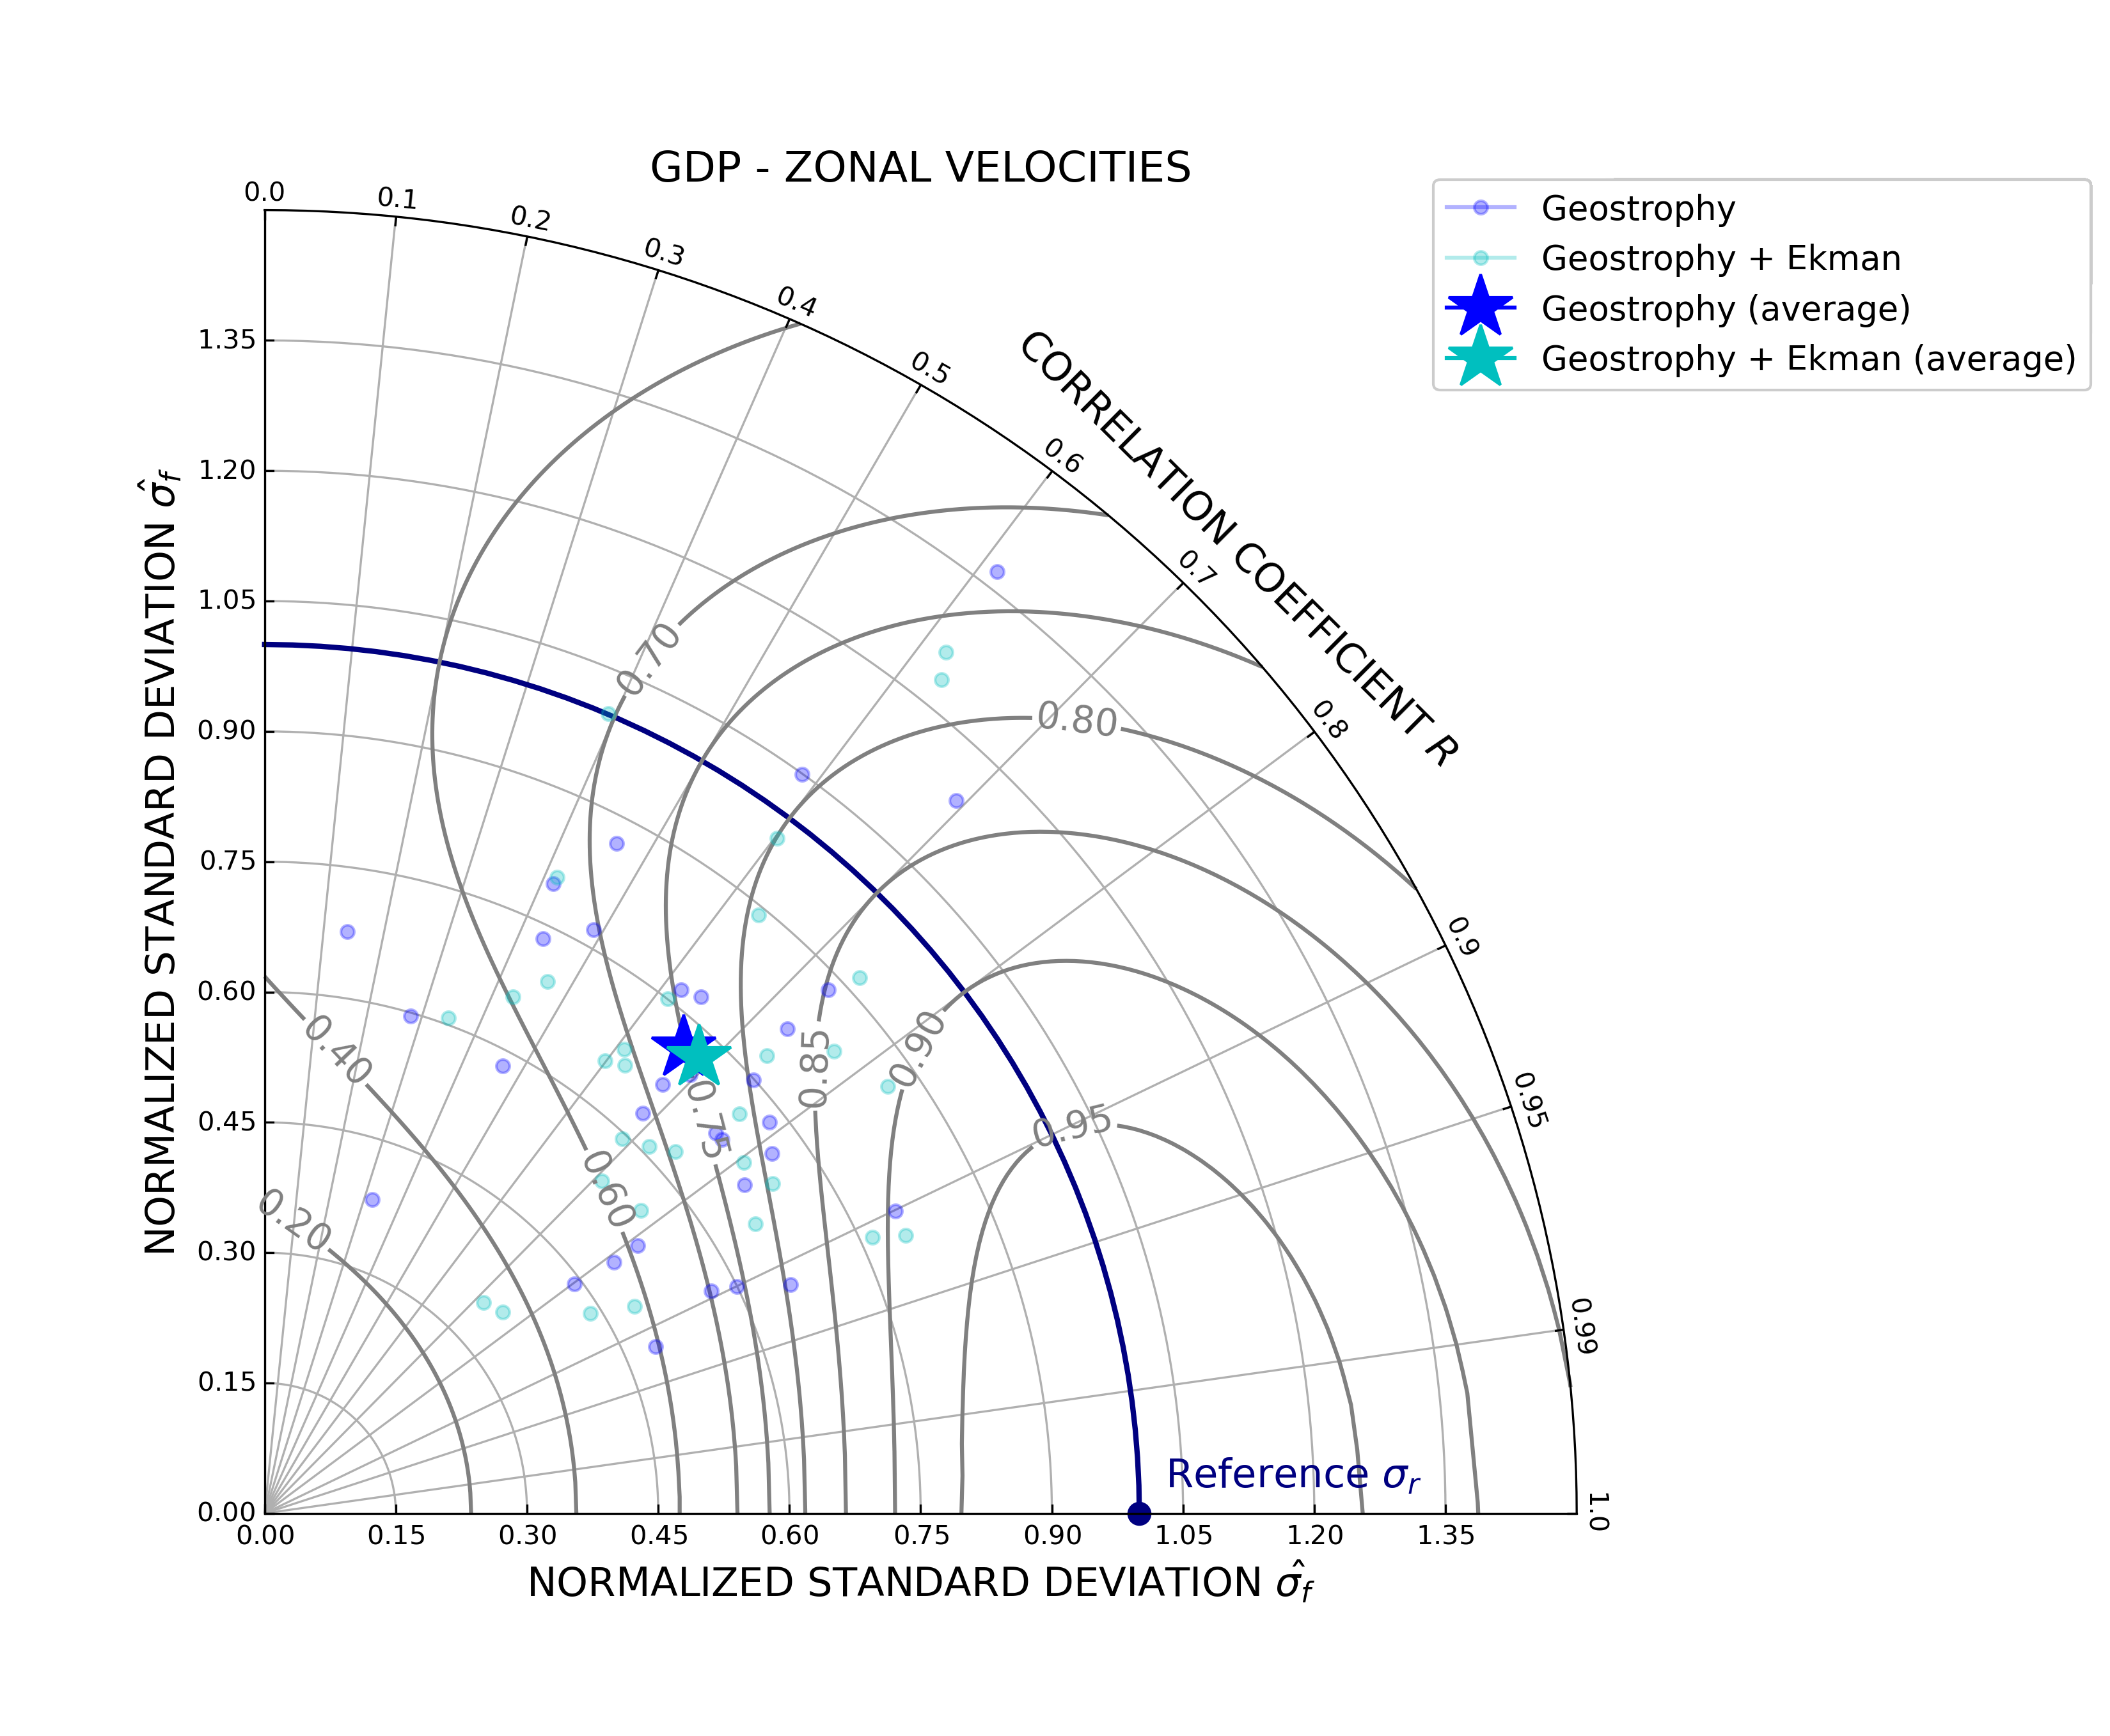

In [10]:
# Standard deviation of observed data
obsSTD = 1.0

# Standard deviation of each predicted data
s_geo= np.array(std_u)[:, 1]/np.array(std_u)[:, 0]

s_ek = np.array(std_u)[:, 2]/np.array(std_u)[:, 0]

smean = [
    np.mean(s_geo),
    np.mean(s_ek)
]

s = np.concatenate((s_geo, s_ek, smean), axis=None)

# The correlation coefficient of each predicted data
r_geo = np.array(corr_coeff_u)[:, 0]
r_ek = np.array(corr_coeff_u)[:, 1]

rmean = [
    np.mean(r_geo),
    np.mean(r_ek)
]

r = np.concatenate((r_geo, r_ek, rmean), axis=None)

# Labels of each predicted data
l_geo = ['Geostrophy']*len(s_geo)
l_ek = ['Geostrophy + Ekman']*len(s_ek)

lmean = ['Geostrophy (average)', 'Geostrophy + Ekman (average)']

l = np.concatenate((l_geo, l_ek, lmean), axis=None)

cs = np.concatenate((['b']*len(s_geo), ['c']*len(s_ek), ['b', 'c']), axis=None)

a = (np.zeros(len(std_u)))
a[0] = 1

boolean = np.concatenate((a,a, [True, True]))

# Output file name
fname = 'TaylorDiagram.jpg'

rnd = ['o']*len(std_u)

mark = np.concatenate((rnd, rnd, ['*', '*']))

size = np.ones(len(mark))*5
size[-2:] = 25

alpha = np.ones(len(mark))*0.3
alpha[-2:] = 1

srl(obsSTD, s, r, l, boolean, fname, cs, mark, size, alpha, 'GDP - ZONAL VELOCITIES')

warnings.filterwarnings('ignore')

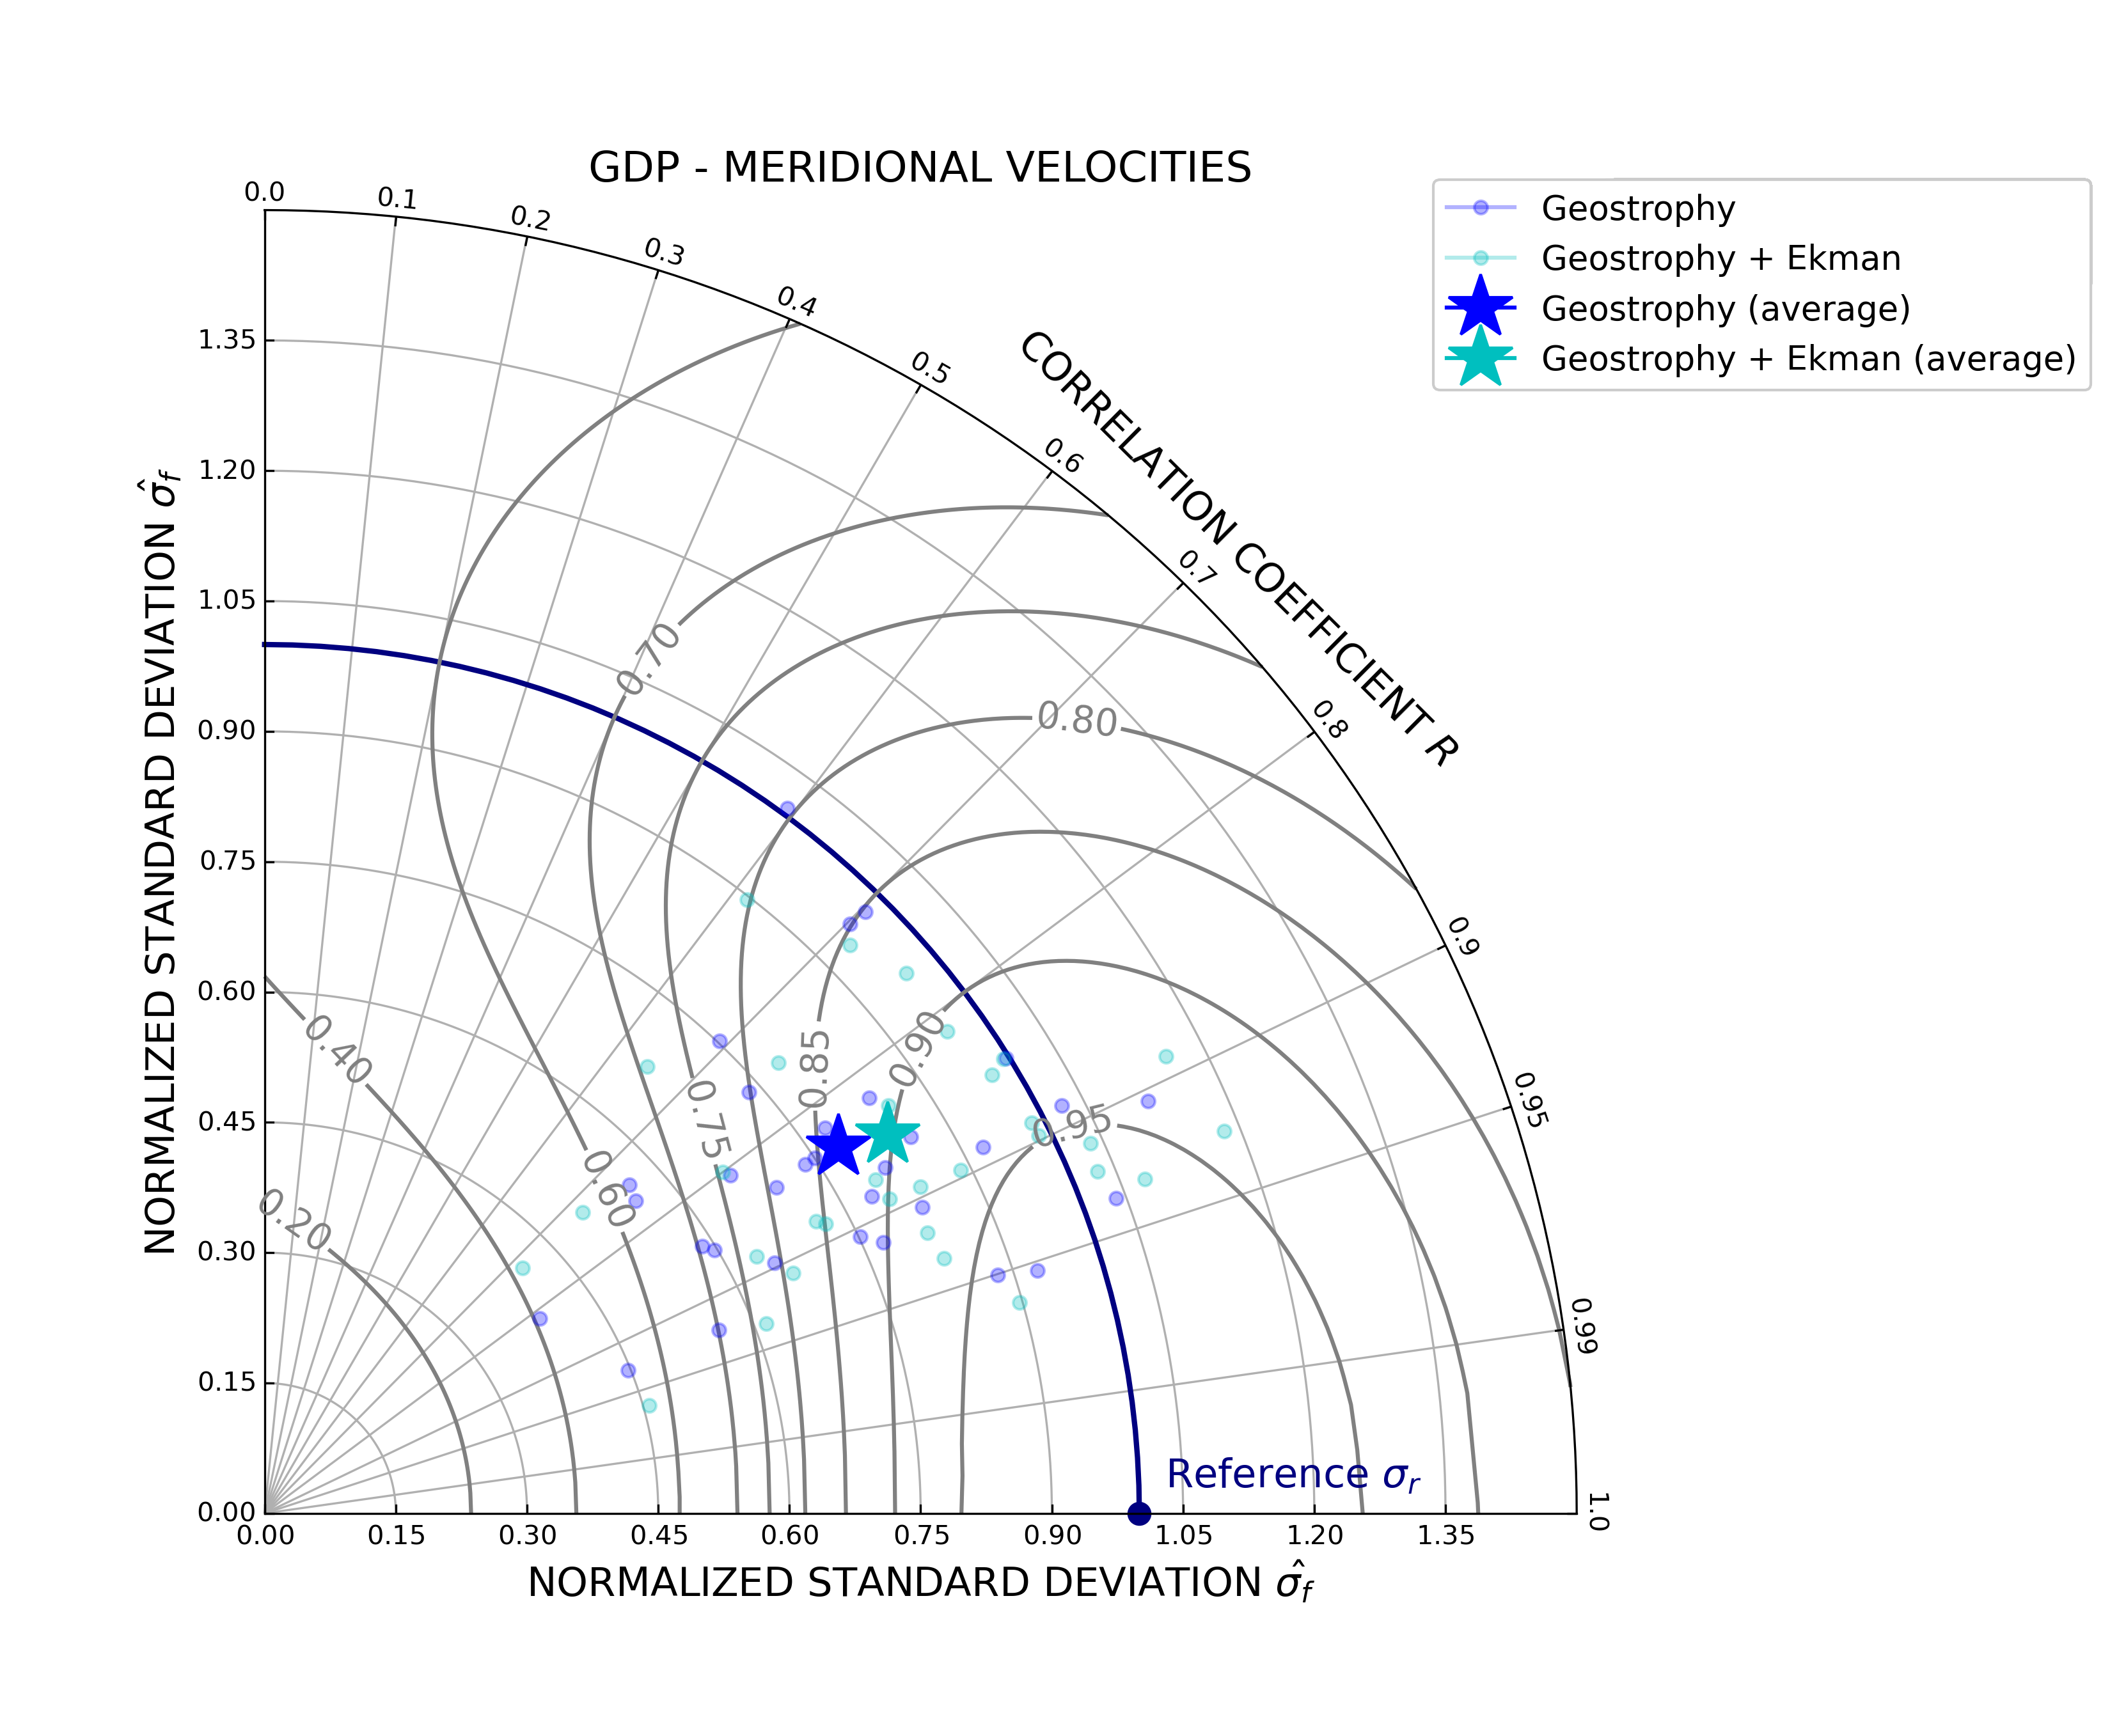

In [11]:
# Standard deviation of observed data
obsSTD = 1.0

# Standard deviation of each predicted data
s_geo= np.array(std_v)[:, 1]/np.array(std_v)[:, 0]

s_ek = np.array(std_v)[:, 2]/np.array(std_v)[:, 0]

smean = [
    np.mean(s_geo),
    np.mean(s_ek)
]

s = np.concatenate((s_geo, s_ek, smean), axis=None)

# The correlation coefficient of each predicted data
r_geo = np.array(corr_coeff_v)[:, 0]
r_ek = np.array(corr_coeff_v)[:, 1]

rmean = [
    np.mean(r_geo),
    np.mean(r_ek)
]

r = np.concatenate((r_geo, r_ek, rmean), axis=None)

# Labels of each predicted data
l_geo = ['Geostrophy']*len(s_geo)
l_ek = ['Geostrophy + Ekman']*len(s_ek)

lmean = ['Geostrophy (average)', 'Geostrophy + Ekman (average)']

l = np.concatenate((l_geo, l_ek, lmean), axis=None)

cs = np.concatenate((['b']*len(s_geo), ['c']*len(s_ek), ['b', 'c']), axis=None)

a = (np.zeros(len(std_v)))
a[0] = 1

boolean = np.concatenate((a,a, [True, True]))

# Output file name
fname = 'TaylorDiagram.jpg'

rnd = ['o']*len(std_v)

mark = np.concatenate((rnd, rnd, ['*', '*']))

size = np.ones(len(mark))*5
size[-2:] = 25

alpha = np.ones(len(mark))*0.3
alpha[-2:] = 1

srl(obsSTD, s, r, l, boolean, fname, cs, mark, size, alpha, 'GDP - MERIDIONAL VELOCITIES')

warnings.filterwarnings('ignore')

In [12]:
def BootstrapSkillScore(sss, rrr, n=5000):
    # we take the mean of the mean of each experiment
    # and the standard deviation of the mean of the mean of each experiment which is the standard error
    tskill = []

    for i in range(n):

        train_id = sklearn.model_selection.train_test_split(np.arange(len(sss)), test_size=0.1)[0]
        
        meansss = np.mean(sss[train_id])
        meanrrr = np.mean(rrr[train_id])

        R0 = 1
        tss = (4*(1+meanrrr))/(((meansss+(1/meansss))**2) * (1+R0))
        tskill.append(tss)

#     plt.hist(tski)
    print(f'mean = {np.around(np.mean(tskill),2)} +/- {np.around(np.std(tskill)*1.96, 2)}')

In [16]:
print('U VELOCITIES')
print('GEO')   
BootstrapSkillScore(np.array(std_u)[:, 1]/np.array(std_u)[:, 0], np.array(corr_coeff_u)[:, 0])
print('GEO+EK')   
BootstrapSkillScore(np.array(std_u)[:, 2]/np.array(std_u)[:, 0], np.array(corr_coeff_u)[:, 1])


print('V VELOCITIES')
print('GEO')   
BootstrapSkillScore(np.array(std_v)[:, 1]/np.array(std_v)[:, 0], np.array(corr_coeff_v)[:, 0])
print('GEO+EK')   
BootstrapSkillScore(np.array(std_v)[:, 2]/np.array(std_v)[:, 0], np.array(corr_coeff_v)[:, 1])


print('ALONG-SHELF VELOCITIES')
print('GEO')   
BootstrapSkillScore(np.array(std_along)[:, 1]/np.array(std_along)[:, 0], np.array(corr_coeff_along)[:, 0])
print('GEO+EK')   
BootstrapSkillScore(np.array(std_along)[:, 2]/np.array(std_along)[:, 0], np.array(corr_coeff_along)[:, 1])


print('ACROSS-SHELF VELOCITIES')
print('GEO')   
BootstrapSkillScore(np.array(std_across)[:, 1]/np.array(std_across)[:, 0], np.array(corr_coeff_across)[:, 0])
print('GEO+EK')   
BootstrapSkillScore(np.array(std_across)[:, 2]/np.array(std_across)[:, 0], np.array(corr_coeff_across)[:, 1])


U VELOCITIES
GEO
mean = 0.75 +/- 0.02
GEO+EK
mean = 0.76 +/- 0.02
V VELOCITIES
GEO
mean = 0.87 +/- 0.01
GEO+EK
mean = 0.9 +/- 0.01
ALONG-SHELF VELOCITIES
GEO
mean = 0.64 +/- 0.04
GEO+EK
mean = 0.68 +/- 0.03
ACROSS-SHELF VELOCITIES
GEO
mean = 0.68 +/- 0.02
GEO+EK
mean = 0.8 +/- 0.02


In [19]:
rmse_u = np.array(rmse_u)
rmse_v = np.array(rmse_v)
rmse_along = np.array(rmse_along)
rmse_across = np.array(rmse_across)

varexp_u = np.array(varexp_u)
varexp_v = np.array(varexp_v)
varexp_along = np.array(varexp_along)
varexp_across = np.array(varexp_across)

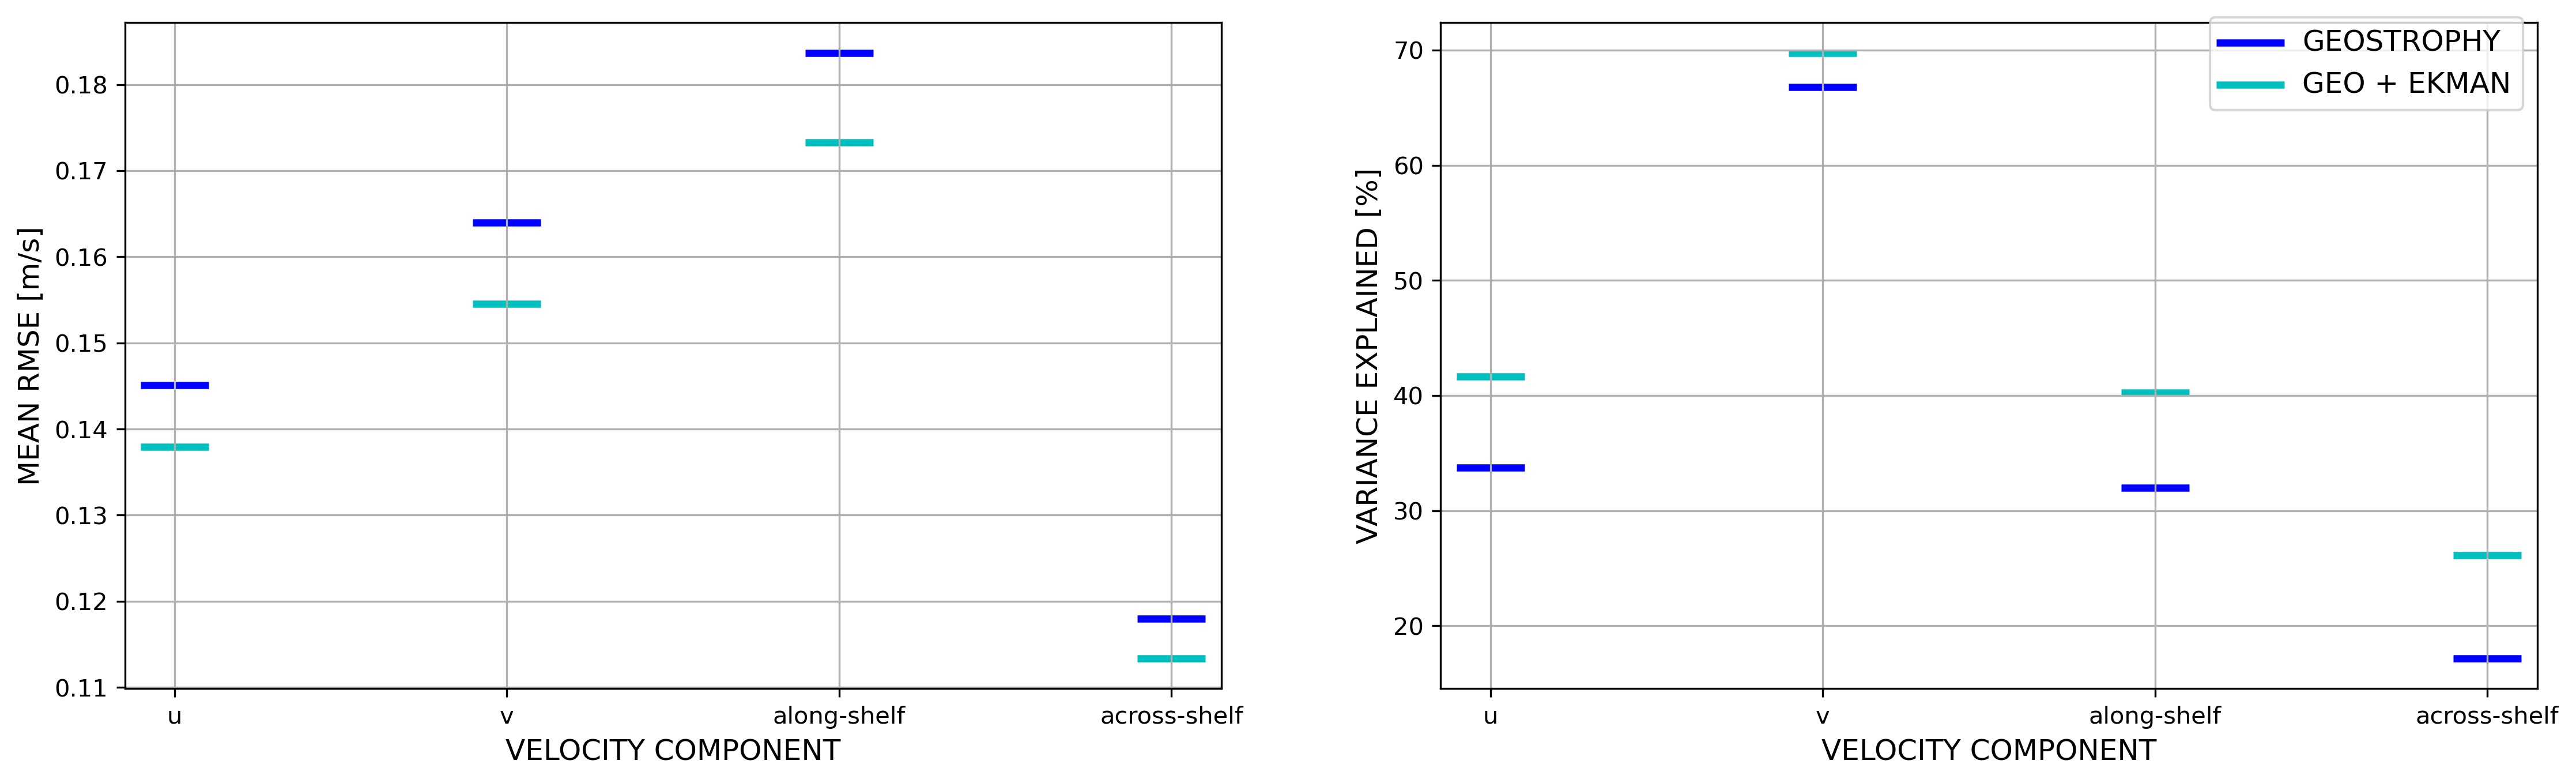

In [20]:
plt.figure(figsize=(18,5), dpi=300)
plt.subplot(121)
plt.scatter(['u', 'v', 'along-shelf', 'across-shelf'], [np.mean(rmse_u[:, 0]),np.mean(rmse_v[:, 0]),np.mean(rmse_along[:, 0]), np.mean(rmse_across[:, 0])], marker='_', s=800, lw=3, c='b', label='GEOSTROPHY')
plt.scatter(['u', 'v', 'along-shelf', 'across-shelf'], [np.mean(rmse_u[:, 1]),np.mean(rmse_v[:, 1]),np.mean(rmse_along[:, 1]), np.mean(rmse_across[:, 1])], marker='_', s=800, lw=3, c='c', label='GEO + EKMAN')

plt.ylabel('MEAN RMSE [m/s]', fontsize=12)
plt.xlabel('VELOCITY COMPONENT', fontsize=12)
plt.grid()

plt.subplot(122)
plt.scatter(['u', 'v', 'along-shelf', 'across-shelf'], [100*np.mean(varexp_u[:, 0]),100*np.mean(varexp_v[:, 0]),100*np.mean(varexp_along[:, 0]), 100*np.mean(varexp_across[:, 0])], marker='_', s=800, lw=3, c='b', label='GEOSTROPHY')
plt.scatter(['u', 'v', 'along-shelf', 'across-shelf'], [100*np.mean(varexp_u[:, 1]),100*np.mean(varexp_v[:, 1]),100*np.mean(varexp_along[:, 1]),100*np.mean(varexp_across[:, 1])], marker='_', s=800, lw=3, c='c', label='GEO + EKMAN')

plt.legend(bbox_to_anchor=(1, 1.03), fontsize=12)
plt.ylabel('VARIANCE EXPLAINED [%]', fontsize=12)
plt.xlabel('VELOCITY COMPONENT', fontsize=12)
plt.grid()